<a href="https://colab.research.google.com/github/LuchoVidalSMN/satelite/blob/master/Genera_transecta_ABI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Librerias y otros

In [1]:
#==============================================================================#

# Este comando "limpia" todas las variables definidas
%reset_selective -f b

# Este comando le indica a Python que las figuras se deben generar dentro
# de la misma Notebook, no en una ventana
%matplotlib inline

#==============================================================================#

!pip install s3fs
!pip install pyproj
!pip install netCDF4
!apt-get install -qq libgdal-dev libproj-dev
!pip install --no-binary shapely shapely --force
!pip install cartopy==0.18.0

import gc
import glob
import s3fs
import netCDF4
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone

import matplotlib.colors as mcolors
import matplotlib.cm as cm

import scipy.ndimage

import cartopy
import cartopy.crs as ccrs
from pyproj import Proj

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

#==============================================================================#

# Defino los limites de paises (descarga por unica vez)
provincias = cartopy.feature.NaturalEarthFeature(category='cultural',
                                                 name='admin_1_states_provinces_lines',
                                                 scale='10m',
                                                 facecolor='none')
   
paises = cartopy.feature.NaturalEarthFeature(category='cultural',
                                             name='admin_0_countries',
                                             scale='10m',
                                             facecolor='none')

#==============================================================================#

# Paleta de colores para los gráficos de IR (Autor: Maite Cancelada)
cdict = {'blue': [(0.0, 0.0, 0.8), (0.076923077, 1, 1), (0.153846154, 0, 0),
                  (0.230769231, 0.0, 0.0),(0.307692308, 0.0, 0.0),(0.384615385, 0.0, 0.0),
                  (0.461538462, 1, 1),(0.538461538, 1, 0.7), (1.0, 0.0, 1)],
         'green': [(0.0, 0.0, 0.0), (0.076923077, 0.6, 1), (0.153846154, 0, 0),
                   (0.230769231, 0.0, 0),(0.307692308, 1,1),(0.384615385, 1, 1),
                   (0.461538462, 0, 0),(0.538461538, 1, 0.7), (1.0, 0.0, 0.0)],
         'red': [(0.0, 0.0, 0.8), (0.076923077, 1, 1), (0.153846154, 0, 0),
                 (0.230769231, 1, 1),(0.307692308, 1, 1),(0.384615385, 0, 0.0),
                 (0.461538462, 0.0, 0.0),(0.538461538, 0, 0.7), (1.0, 0.0, 0)]}
cmap_irw = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,65)

#==============================================================================#

# ROI (tesis Sebastian)
x1_lon = 2850
x2_lon = 3650
y1_lat = 4050
y2_lat = 4710

# LEEMOS UN ARCHIVO PARA EXTRAER MATRIZ LAT/LON Y DIMENSIONES RECORTE
fs = s3fs.S3FileSystem(anon=True)
files0 = fs.ls('noaa-goes16/ABI-L2-CMIPF/2019/001/12/')
arch_c13 = [i for i in files0 if 'CMIPF' in i and 'M3C13' in i][0]
with fs.open(arch_c13) as f:
  with netCDF4.Dataset(arch_c13.split('/')[-1], memory=f.read()) as goes:
    H = goes.variables['goes_imager_projection'].getncattr('perspective_point_height')
    lon_0 = goes.variables['goes_imager_projection'].getncattr('longitude_of_projection_origin')
    sat_sweep = goes.variables['goes_imager_projection'].getncattr('sweep_angle_axis')
    x = goes.variables['x'][x1_lon:x2_lon] * H
    y = goes.variables['y'][y1_lat:y2_lat] * H
    xv, yv = np.meshgrid(np.array(x), np.array(y))
    # Doc: https://proj.org/operations/projections/geos.html
    geo = Proj(proj='geos', h=H, lon_0=lon_0, sweep=sat_sweep)
    lons, lats = geo(xv, yv, inverse=True)
    
#==============================================================================#

# FUNCION CALCULO TRANSECTA

def get_transect(lon0,lat0,lon1,lat1,num) :

  dist = np.power((lats-lat0)*(lats-lat0) + (lons-lon0)*(lons-lon0),0.5)
  row0, col0 = np.where(dist==np.min(dist))
  row0 = row0[0]
  col0 = col0[0]

  dist = np.power((lats-lat1)*(lats-lat1) + (lons-lon1)*(lons-lon1),0.5)
  row1, col1 = np.where(dist==np.min(dist))
  row1 = row1[0]
  col1 = col1[0]
  
  x, y = np.linspace(row0, row1, num), np.linspace(col0, col1, num)

  # Extract the values along the line, using cubic interpolation
  trslat = scipy.ndimage.map_coordinates(lats, np.vstack((x,y)))
  trslon = scipy.ndimage.map_coordinates(lons, np.vstack((x,y)))
  trsdat = scipy.ndimage.map_coordinates(data, np.vstack((x,y)))

  return trslat, trslon, trsdat

#==============================================================================#


  Using cached https://files.pythonhosted.org/packages/42/f3/0e1bc2c4f15e05e30c6b99322b9ddaa2babb3f43bc7df2698efdc1553439/Shapely-1.7.1.tar.gz
Skipping wheel build for shapely, due to binaries being disabled for it.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Shapely 1.7.1
    Uninstalling Shapely-1.7.1:
      Successfully uninstalled Shapely-1.7.1
    Running setup.py install for shapely ... done


# 2. Lectura de datos

In [2]:

# FECHA Y HORA DE INETERES PARA ANALIZAR
fecha = '201811102000' # Formato: yyyymmddHHMM (La hora en UTC)

# ABI TECHNICAL SUMMARY CHART
# https://www.goes-r.gov/spacesegment/ABI-tech-summary.html

fecha0 = datetime.strptime(fecha, '%Y%m%d%H%M')

files = fs.ls('noaa-goes16/ABI-L2-CMIPF/'+fecha0.strftime('%Y')+'/'+fecha0.strftime('%j')+'/'+fecha0.strftime('%H')+'/')
files_C13 = [i for i in files if 'CMIPF' in i and 'M3C13' in i]

fname = files_C13[0]
with fs.open(fname) as f:
  with netCDF4.Dataset(fname.split('/')[-1], memory=f.read()) as goes:
    data = goes.variables['CMI'][y1_lat:y2_lat,x1_lon:x2_lon][::1,::1]
    add_seconds = int(goes.variables['time_bounds'][0])
    date = datetime(2000,1,1,12) + timedelta(seconds=add_seconds)
gc.collect()


85

# 3. Transecta arbitraria

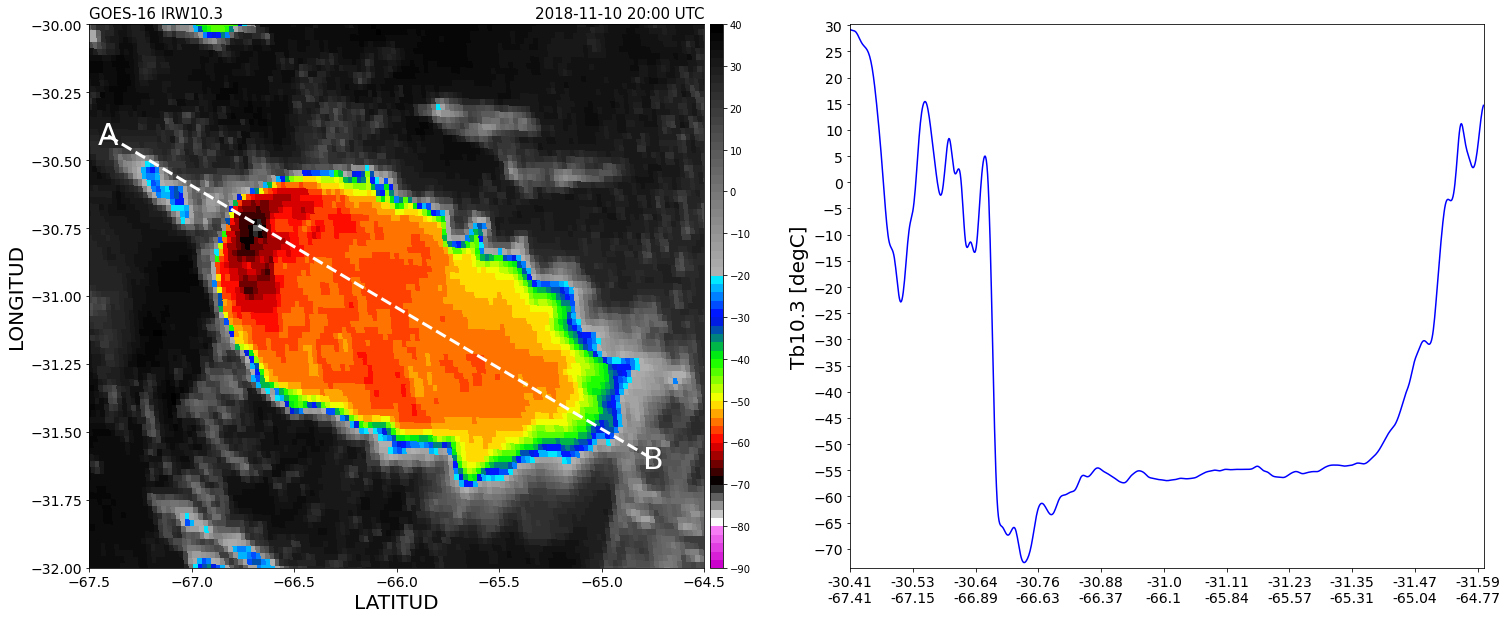

In [3]:

#==============================================================================#

# PARAMETROS DE CONFIGURACION PARA CALCULO DE TRANSECTA

# Coordenadas del punto de inicio (A)
lon0, lat0 = -67.4, -30.4

# Coordenadas del punto de fin (B)
lon1, lat1 = -64.75, -31.6

# Cantidad de puntos a usar en la interpolación
num = 1000

# Función para calcular la transecta
trslat, trslon, trsdat = get_transect( lon0, lat0, lon1, lat1, num )

#==============================================================================#

plt.figure(figsize=(25,10))

# PLOT IMAGEN DE REFERENCIA

plt.subplot(121)
img=plt.pcolormesh(lons, lats, data-273, cmap=cmap_irw, vmin=-90, vmax=40)
plt.colorbar(img, fraction=0.02, pad=0.01, aspect=45, ticks=np.arange(-100.,100.01,10.0))
plt.plot(trslon, trslat, '--w', lw=3)
plt.text(trslon[0], trslat[0], 'A', c='w', fontsize=30, horizontalalignment='center', verticalalignment='center') # Punto de inicio
plt.text(trslon[-1], trslat[-1], 'B', c='w', fontsize=30, horizontalalignment='center', verticalalignment='center') # Punto de inicio
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('LATITUD', fontsize=20)
plt.ylabel('LONGITUD', fontsize=20)
plt.title('GOES-16 IRW10.3', fontsize=15, loc='left')
plt.title(date.strftime('%Y-%m-%d %H:%M UTC'), fontsize=15, loc='right')
plt.xlim([-67.5, -64.5])
plt.ylim([-32, -30])

# PLOT TRANSECTA

plt.subplot(122)
plt.plot(trsdat-273, '-b')
plt.xticks(fontsize=14)
xlab1 = np.around(trslat[0:num:99],2)
xlab2 = np.around(trslon[0:num:99],2)
xlabels = [f'{str(x1)}\n{str(x2)}' for x1, x2, in zip(xlab1,xlab2)]
plt.xticks(np.arange(0,num,99), fontsize=14, labels=xlabels)
plt.yticks(np.arange(-100,40,5), fontsize=14)
plt.ylabel('Tb10.3 [degC]', fontsize=20)
plt.xlim([0,num])
plt.ylim([np.min(trsdat-273)-1, np.max(trsdat-273)+1])

plt.show()

#==============================================================================#
